# Memberi label pada kumpulan data menggunakan BLIP-2

Di notebook ini, kami akan mendemonstrasikan cara membuat kumpulan data berlabel menggunakan BLIP-2 dan memasukkannya ke hub Hugging Face.  BLIP-2, yang melakukan pembuatan gambar-ke-teks zero-shot, diperkenalkan di [BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models](https://arxiv.org/pdf /2301.12597.pdf) oleh Li, et. al. BLIP-2 bootstrap membekukan gambar dan LLM yang telah dilatih sebelumnya, menjembatani kesenjangan modalitas dengan Querying Transformer (Q-Former). Anda dapat membaca lebih lanjut tentang BLIP-2 [di sini](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/blip-2).

Catatan:

* Disarankan untuk menjalankan notebook ini pada lingkungan GPU, RAM tinggi.

* Buku catatan ini diadaptasi dari [di sini](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BLIP-2/Chat_with_BLIP_2_%5Bint8_bitsandbytes%5D.ipynb).

Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [1]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


First, let's install the dependencies.

In [2]:
!pip install -q accelerate bitsandbytes datasets huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Let's log into the Hugging Face hub with our "WRITE" access token.

In [9]:
from huggingface_hub import notebook_login

notebook_login()

We need CUDA to run this notebook.

In [10]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Keterangan gambar

Kami menggunakan model BLIP-2 dan prosesor yang sesuai. Kami akan memuat pos pemeriksaan BLIP-2 yang memanfaatkan model OPT terlatih oleh Meta AI, yang memiliki 2,7 miliar parameter. Perhatikan bahwa meskipun kami akan menggunakan inferensi 8-bit menggunakan Bitsandbytes--yang sangat mengurangi kebutuhan memori--Anda dapat menggunakan tipe d lainnya. Anda dapat mempelajari lebih lanjut tentang model ini [di sini](https://huggingface.co/Salesforce/blip2-opt-2.7b).

In [11]:
# URL for the dataset images
url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/label_dataset_owlv2"

# Number of images to process
num_images = 10

# Prompt for image labeling
prompt = "This is a photo of"

# Function to process and label an image
def add_images(idx):
    # Load processor and model
    processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True
    )

    # Get the image URL
    image_url = f"{url}/{idx}.jpeg"

    # Download the image
    response = requests.get(image_url)
    image_content = response.content
    image = Image.open(BytesIO(image_content))

    # Prepare inputs for the model
    inputs = processor(image, text=prompt, return_tensors="pt").to(
        device, torch.float16
    )

    # Generate labels
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return {
        "image": image,
        "label": label,
    }

# Generator function for the dataset
def generate_entries():
    for i in range(num_images):
        yield add_images(i)


Kami sekarang siap untuk memasukkan kumpulan data kami ke hub Hugging Face. Kami memiliki beberapa opsi tentang cara melakukan ini.

* Gunakan folder gambar dengan file metajsonl
* Gunakan generator

Kami akan melakukan demo menggunakan metode generator, yang merupakan cara hemat memori untuk membuat kumpulan data karena melakukan iterasi melalui gambar. Anda dapat membaca selengkapnya tentang menambahkan kumpulan data [di sini](https://huggingface.co/docs/datasets/en/create_dataset).

In [12]:
from datasets import Dataset

username = "Hazelnut27"
repo_id = "labeled_images_demo_BLIP2"

# Create a dataset from the generator
ds = Dataset.from_generator(generate_entries)
ds.push_to_hub(f"{username}/{repo_id}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Hazelnut27/labeled_images_demo_BLIP2/commit/deb350555ec4c3b7ea59ce3a1719f2bef6145656', commit_message='Upload dataset', commit_description='', oid='deb350555ec4c3b7ea59ce3a1719f2bef6145656', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Hazelnut27/labeled_images_demo_BLIP2', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Hazelnut27/labeled_images_demo_BLIP2'), pr_revision=None, pr_num=None)

Let's check out our new dataset by downloading it from the hub.

In [13]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("kfahn/labeled_images_demo_BLIP2")

README.md:   0%|          | 0.00/307 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/585k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's take a look at one of the images.

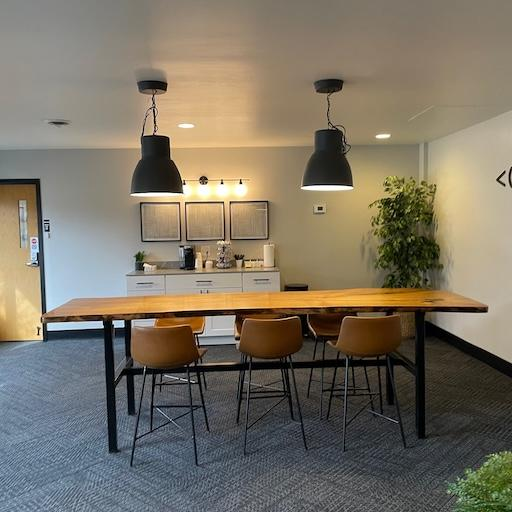

In [14]:
dataset["train"]["image"][0]

Now let's take a look at the label: it is 'a conference room with a table and chairs.' The model provided an accurate label!

In [15]:
dataset["train"]["label"][0]

'a conference room with chairs and a table'